In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SmartSales").getOrCreate()



In [8]:
db_path = "jdbc:sqlite:/Users/b/Documents/smart-store-brandon/Data/dw/smart_sales.db"

df_sales = spark.read.format("jdbc") \
    .option("url", db_path) \
    .option("dbtable", "sales_transaction") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_sales.show(5)


+--------------+-----------+----------+---------+-----------+------------+------------+
|transaction_id|customer_id|product_id|sale_date|sale_amount|bonus_points|payment_type|
+--------------+-----------+----------+---------+-----------+------------+------------+
|           550|       1008|       102| 1/6/2024|       39.1|         0.0|        Cash|
|           551|       1009|       105| 1/6/2024|      19.78|         0.0|      Credit|
|           552|       1004|       107|1/16/2024|      335.1|         0.0|       Debit|
|           553|       1006|       102|1/16/2024|      195.5|         0.0|      Credit|
|           554|       1005|       102|1/25/2024|      117.3|         0.0|        Cash|
+--------------+-----------+----------+---------+-----------+------------+------------+
only showing top 5 rows



In [8]:
db_path = "jdbc:sqlite:/Users/b/Documents/smart-store-brandon/Data/dw/smart_sales.db"

df_sales = spark.read.format("jdbc") \
    .option("url", db_path) \
    .option("dbtable", "sales_transaction") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_customer = spark.read.format("jdbc") \
    .option("url", db_path) \
    .option("dbtable", "customer") \
    .option("driver", "org.sqlite.JDBC") \
    .load()

df_product = spark.read.format("jdbc") \
    .option("url", db_path) \
    .option("dbtable", "product") \
    .option("driver", "org.sqlite.JDBC") \
    .load()



In [9]:
df_sales.createOrReplaceTempView("sales")
df_customer.createOrReplaceTempView("customer")
df_product.createOrReplaceTempView("product")


In [10]:
df_top_customers = spark.sql("""
SELECT 
    c.customer_id,
    c.name AS customer_name,
    SUM(s.sale_amount) AS total_spent
FROM sales s
JOIN customer c ON s.customer_id = c.customer_id
GROUP BY c.customer_id, c.name
ORDER BY total_spent DESC
""")

df_top_customers.show()


+-----------+----------------+------------------+
|customer_id|   customer_name|       total_spent|
+-----------+----------------+------------------+
|       1001|   William White|23752.520000000004|
|       1010|Hermione Granger|          22822.54|
|       1007|   Susan Johnson|           12422.6|
|       1004|       Chewbacca|11813.439999999999|
|       1006|   Tiffany James|          11715.82|
|       1011| Hermione Grager|           8750.94|
|       1002|    Wylie Coyote|           7434.44|
|       1005|          Dr Who|4064.8599999999997|
|       1003|       Dan Brown|2427.2999999999997|
|       1009|    Jason Bourne|           1806.34|
|       1008|      Tony Stark|           1545.54|
+-----------+----------------+------------------+



In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SmartSales").getOrCreate()


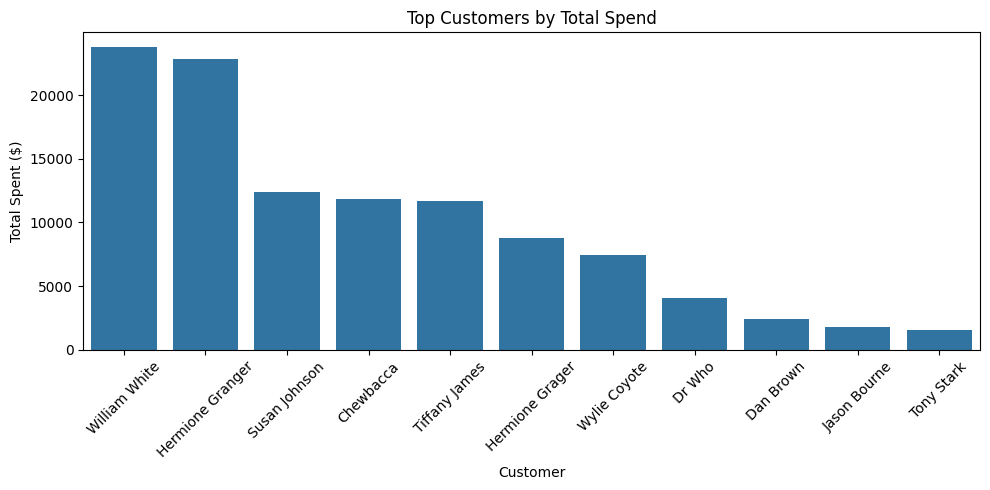

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
df_top_customers_pd = df_top_customers.toPandas()

# Create bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=df_top_customers_pd, x="customer_name", y="total_spent")
plt.xticks(rotation=45)
plt.title("Top Customers by Total Spend")
plt.xlabel("Customer")
plt.ylabel("Total Spent ($)")
plt.tight_layout()
plt.show()


In [15]:
from pyspark.sql.functions import year, month

df_sales = df_sales.withColumn("sale_year", year("sale_date"))
df_sales = df_sales.withColumn("sale_month", month("sale_date"))

df_sales.createOrReplaceTempView("sales")  # update the SQL view


In [16]:
df_monthly_sales = spark.sql("""
SELECT 
    sale_year, 
    sale_month, 
    SUM(sale_amount) AS total_sales
FROM sales
GROUP BY sale_year, sale_month
ORDER BY sale_year, sale_month
""")

df_monthly_sales.show()


+---------+----------+------------------+
|sale_year|sale_month|       total_sales|
+---------+----------+------------------+
|     NULL|      NULL|108556.34000000004|
+---------+----------+------------------+



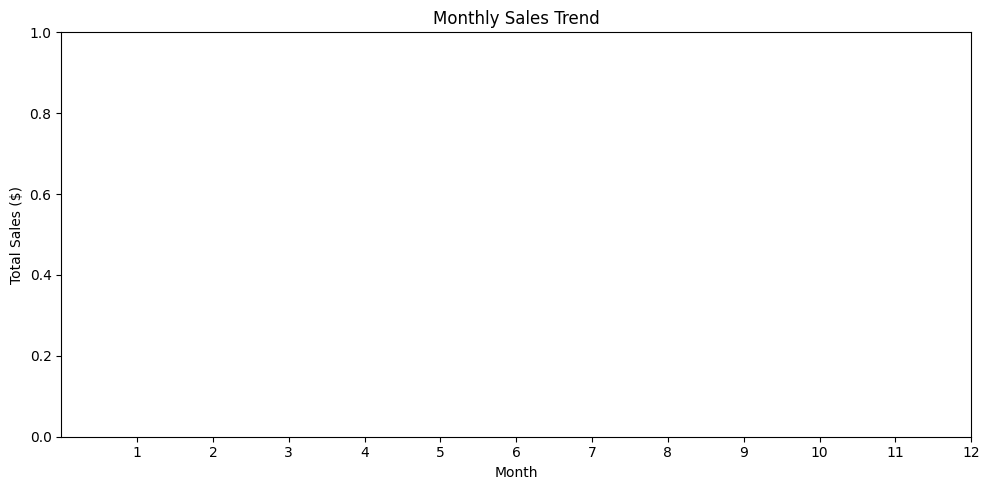

In [17]:
df_monthly_sales_pd = df_monthly_sales.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_monthly_sales_pd, x="sale_month", y="total_sales", hue="sale_year", marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


In [18]:
df_dice = spark.sql("""
SELECT 
    p.category,
    s.payment_type,
    SUM(s.sale_amount) AS total_sales
FROM sales s
JOIN product p ON s.product_id = p.product_id
GROUP BY p.category, s.payment_type
ORDER BY total_sales DESC
""")

df_dice.show()


+-----------+------------+------------------+
|   category|payment_type|       total_sales|
+-----------+------------+------------------+
|   Clothing|      Credit|            6444.4|
|   Clothing|       Debit|           4690.34|
|   Clothing|        Cash|           2290.14|
|Electronics|      Credit|            2224.5|
|Electronics|        Cash|            1469.2|
|Electronics|       Debit|            943.56|
|     Sports|      Credit|296.70000000000005|
|     Sports|       Debit|            257.14|
|     Sports|        Cash|            118.68|
+-----------+------------+------------------+



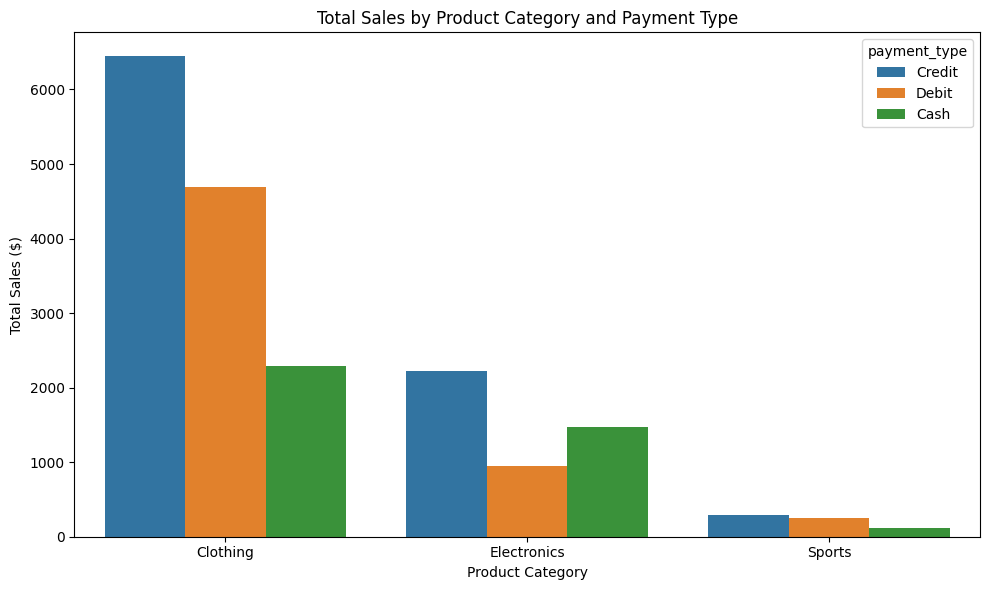

In [19]:
df_dice_pd = df_dice.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dice_pd, x="category", y="total_sales", hue="payment_type")
plt.title("Total Sales by Product Category and Payment Type")
plt.xlabel("Product Category")
plt.ylabel("Total Sales ($)")
plt.tight_layout()
plt.show()


In [20]:
df_2024 = spark.sql("""
SELECT *
FROM sales
WHERE sale_date BETWEEN '2024-01-01' AND '2024-12-31'
""")

df_2024.show(5)


+--------------+-----------+----------+---------+-----------+------------+------------+---------+----------+
|transaction_id|customer_id|product_id|sale_date|sale_amount|bonus_points|payment_type|sale_year|sale_month|
+--------------+-----------+----------+---------+-----------+------------+------------+---------+----------+
+--------------+-----------+----------+---------+-----------+------------+------------+---------+----------+



In [21]:
from pyspark.sql.functions import year, quarter, month

df_sales = df_sales.withColumn("sale_year", year("sale_date"))
df_sales = df_sales.withColumn("sale_quarter", quarter("sale_date"))
df_sales = df_sales.withColumn("sale_month", month("sale_date"))

df_sales.createOrReplaceTempView("sales")


In [22]:
df_drilldown = spark.sql("""
SELECT 
    sale_year,
    sale_quarter,
    sale_month,
    SUM(sale_amount) AS total_sales
FROM sales
GROUP BY sale_year, sale_quarter, sale_month
ORDER BY sale_year, sale_quarter, sale_month
""")

df_drilldown.show()


+---------+------------+----------+------------------+
|sale_year|sale_quarter|sale_month|       total_sales|
+---------+------------+----------+------------------+
|     NULL|        NULL|      NULL|108556.34000000004|
+---------+------------+----------+------------------+



In [26]:
# Monthly sales grouped by precomputed sale_month and filtered for 2024
df_2024_trend = spark.sql("""
SELECT 
    sale_month,
    SUM(sale_amount) AS monthly_sales
FROM sales
WHERE sale_year = 2024
GROUP BY sale_month
ORDER BY sale_month
""")




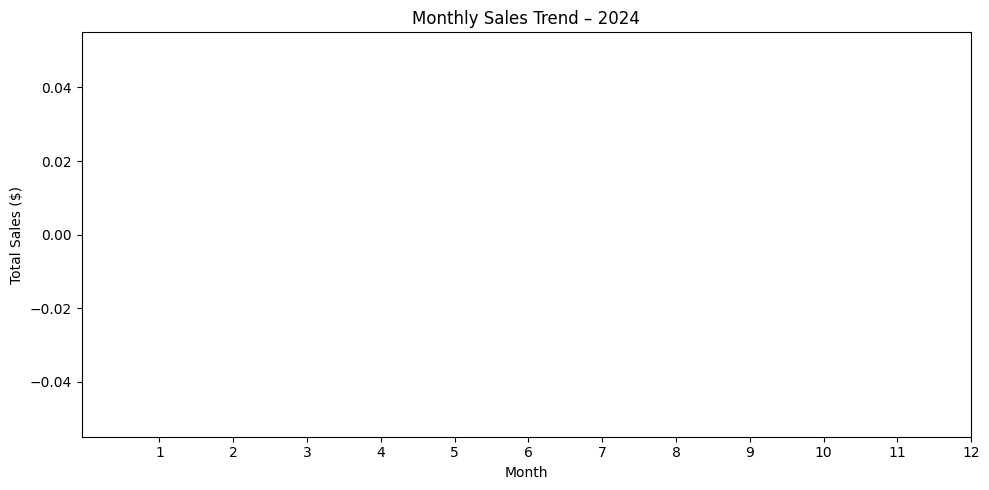

In [27]:
# Convert to Pandas
df_2024_trend_pd = df_2024_trend.toPandas()

# Plot it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_2024_trend_pd, x="sale_month", y="monthly_sales", marker="o")
plt.title("Monthly Sales Trend – 2024")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()
